# IMMC 2020: With Variable Heuristic and Proper Product List
### Importing Modules and Data

In [53]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
crowd_avoidance = 0.5

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [54]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [55]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [56]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [57]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [58]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [59]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [60]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(int(max_shelf_capacity/unit_size), total_qty)
        print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

index 0 department TV&Home Theater qty 8 net_size 16.10151668
index 1 department Computers&Tablets qty 10 net_size 1.084217678
index 2 department Computers&Tablets qty 8 net_size 0.8673741424
index 3 department Computers&Tablets qty 10 net_size 1.084217678
index 4 department Computers&Tablets qty 8 net_size 0.8673741424
index 5 department Computers&Tablets qty 8 net_size 0.8673741424
index 6 department Computers&Tablets qty 10 net_size 1.084217678
index 7 department Computers&Tablets qty 8 net_size 0.8673741424
index 8 department Computers&Tablets qty 8 net_size 0.8673741424
index 9 department Computers&Tablets qty 10 net_size 1.084217678
index 10 department Computers&Tablets qty 10 net_size 1.084217678
index 11 department TV&Home Theater qty 10 net_size 20.12689585
index 12 department TV&Home Theater qty 12 net_size 38.310133404
index 13 department TV&Home Theater qty 12 net_size 38.310133404
index 14 department TV&Home Theater qty 12 net_size 38.310133404
index 15 department TV&Home 

index 113 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 114 department Appliances qty 1 net_size 100.0
index 115 department Appliances qty 1 net_size 100.0
index 115 department Appliances qty 1 net_size 100.0
index 115 department Appliances qty 1 net_size 100.0
index 115 department Appliances qty 1 net_size 100.0
index 115 department Appliances qty 1 net_size 100.0
index 116 department Appliances qty 1 net_size 100.0
index 116 department Appliances qty 1 net_size 100.0
index 116 department Appliances qty 1 net_size 100.0
index 116 department Appliances qty 1 net_size 100.0
index 116 department Appliances qty 1 net_size

In [61]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty

for department, total_pop in department_popularities.items():
    print("Department:", department, "Average Popularity", total_pop/department_qty[department])

Department: Appliances Average Popularity 0.8155674215018757
Department: Audio Average Popularity 0.7490197320470443
Department: Cameras Average Popularity 0.7787335325753125
Department: Cell Phones Average Popularity 0.734969213567913
Department: Computers&Tablets Average Popularity 0.7910655224522162
Department: TV&Home Theater Average Popularity 0.7995588391995322
Department: Video Gaming Average Popularity 0.8057095230819985


In [62]:
pdt_list[4].index

4

## Creating Shelf Class and Layout Object

In [63]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [64]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        #print("pdt list len", len(self.pdt_list))
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        shelf.pdt_set.discard(chosen_pdt_index)
                    else:
                        shelf.pdts[i].qty-= 1
                    break
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        # Conduct A*
        delta = [(1,0), (-1,0), (0,1), (0,-1)]
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                # print("init", init)
                # print("goal", [y,x])
                if path == "FAIL":
                    z=0
                    #print("FAILURE TO REACH SHELF by going to ", [y,x])
                else:
                    for cell in path:
                        #print("walked", cur_size)
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = 3
        max_size = 300
        
        cur_number_of_pdt = 0
        cur_size = random.randint(40, 60)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        
        # Walk to Exit [cur_price == 0 because they aready paid]
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        print("--Finishing Shopper--")
                
        return copy.deepcopy(self.shopper_density_grid)
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                self.price_density_grid[i][j] *= (self.value_of_goods_bought/total_price)
                self.price_density_grid[i][j] = int(self.price_density_grid[i][j])
        
        return copy.deepcopy(self.price_density_grid)
    
    def get_shopper_grid(self):
        return self.shopper_density_grid

## Calculating Product Damage
### Collision Damage / Self-Drops

In [65]:
def loss(shopper_density, price_density):
    p_collision = (min(shopper_density, 300)) **2 / (300*300)
    return p_collision*price_density

def total_loss(shopper_density_grid, price_density_grid):
    net_loss = 0
    for y in range(len(shopper_density_grid)):
        for x in range(len(shopper_density_grid)):
            net_loss += loss(shopper_density_grid[y][x], price_density_grid[y][x])

    return net_loss


## Simulate Layout in Figure 1
### Create and Process Layout

In [66]:
def split_row(word): 
    return [char for char in word]  

In [67]:
fig_1_layout =r'''
000aaaaaaaaaa00000aaaaaaaaaa0000aaaaaaaaaa00000a
00000000000000000000000000000000000000000000000a
b0000000000000000000000000000000000000000000000a
b00000000000000000000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a
b00bbb00ccc00ccc00d000d000d000d000d0000000fff00a
b00bbb00ccc00ccc00dd00dd00dd00dd00dd000000fff00a
b00bbb00ccc00ccc00dd00dd00dd00dd00dd000000fff00a
b000000000000000000dd00dd00dd00dd00dd0000000000a
b000000000000000000dd00dd00dd00dd00dd0000000000a

b00bbb00ccc00ccc00000000000000000000000000fff00a
b00bbb00ccc00ccc0000ddddd00ddddd00ddddd000fff00a
b00bbb00ccc00ccc0000ddddd00ddddd00ddddd000fff00a
b00000000000000000000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a
b00bbb00ccc00ccc0000ddddd00ddddd00ddddd000fff00a
b00bbb00ccc00ccc0000ddddd00ddddd00ddddd000fff00a
b00bbb00ccc00ccc00000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a

b00000000000000000000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a
b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg000fff00a
b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg00000000a
b0ee0ee0ee0ee0ee0000000000000000000000000000000a
b0ee0ee0ee0ee0ee00000000000000000000000000fff00a
b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg000fff00a
b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg000fff00a
b0ee0ee0ee0ee0ee00000000000000000000000000fff00a
b0ee0ee0ee0ee0ee00000000000000000000000000fff00a

b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg000fff00a
b0ee0ee0ee0ee0ee00000gg00gggggggggg00gg000fff00a
b0ee0ee0ee0ee0ee00000000000000000000000000fff00a
b00000000000000000000gg00gggg00ggg00ggg000fff00a
b00000000000000000000gg00gggg00ggg00ggg000fff00a
b0000000000000000000000000000000000000000000000a
b00000000000000000000000000000000000000000fff00a
b00000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a

000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff00a
000000000000000000000000000000000000000000fff000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000


'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])

In [68]:
department_dictionary = {
    "a": "Appliances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers&Tablets",
    "f": "TV&Home Theater",
    "g": "Video Gaming",
}
shelf_list = [shelf("")]
shelf_counter = 1
for (letter, department_name) in department_dictionary.items():
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if str(fig_1_layout[y][x]) == letter:
                print("found shelf", shelf_counter, "department:", department_name)
                fig_1_layout[y][x] = str(shelf_counter)
                shelf_counter += 1
                shelf_list.append(shelf(department_name))

for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        if not str(fig_1_layout[y][x]).isdigit():
            fig_1_layout[y][x] = str(shelf_counter)
            shelf_counter +=1
        fig_1_layout[y][x] = int(fig_1_layout[y][x])
        
        
    
max_shelf_index = shelf_counter

found shelf 1 department: Appliances
found shelf 2 department: Appliances
found shelf 3 department: Appliances
found shelf 4 department: Appliances
found shelf 5 department: Appliances
found shelf 6 department: Appliances
found shelf 7 department: Appliances
found shelf 8 department: Appliances
found shelf 9 department: Appliances
found shelf 10 department: Appliances
found shelf 11 department: Appliances
found shelf 12 department: Appliances
found shelf 13 department: Appliances
found shelf 14 department: Appliances
found shelf 15 department: Appliances
found shelf 16 department: Appliances
found shelf 17 department: Appliances
found shelf 18 department: Appliances
found shelf 19 department: Appliances
found shelf 20 department: Appliances
found shelf 21 department: Appliances
found shelf 22 department: Appliances
found shelf 23 department: Appliances
found shelf 24 department: Appliances
found shelf 25 department: Appliances
found shelf 26 department: Appliances
found shelf 27 depart

found shelf 240 department: Cell Phones
found shelf 241 department: Cell Phones
found shelf 242 department: Cell Phones
found shelf 243 department: Cell Phones
found shelf 244 department: Cell Phones
found shelf 245 department: Cell Phones
found shelf 246 department: Cell Phones
found shelf 247 department: Cell Phones
found shelf 248 department: Cell Phones
found shelf 249 department: Cell Phones
found shelf 250 department: Cell Phones
found shelf 251 department: Cell Phones
found shelf 252 department: Cell Phones
found shelf 253 department: Cell Phones
found shelf 254 department: Cell Phones
found shelf 255 department: Cell Phones
found shelf 256 department: Cell Phones
found shelf 257 department: Cell Phones
found shelf 258 department: Cell Phones
found shelf 259 department: Cell Phones
found shelf 260 department: Cell Phones
found shelf 261 department: Cell Phones
found shelf 262 department: Cell Phones
found shelf 263 department: Cell Phones
found shelf 264 department: Cell Phones


found shelf 568 department: Video Gaming
found shelf 569 department: Video Gaming
found shelf 570 department: Video Gaming
found shelf 571 department: Video Gaming
found shelf 572 department: Video Gaming
found shelf 573 department: Video Gaming
found shelf 574 department: Video Gaming
found shelf 575 department: Video Gaming
found shelf 576 department: Video Gaming
found shelf 577 department: Video Gaming
found shelf 578 department: Video Gaming
found shelf 579 department: Video Gaming
found shelf 580 department: Video Gaming
found shelf 581 department: Video Gaming
found shelf 582 department: Video Gaming
found shelf 583 department: Video Gaming
found shelf 584 department: Video Gaming
found shelf 585 department: Video Gaming
found shelf 586 department: Video Gaming
found shelf 587 department: Video Gaming
found shelf 588 department: Video Gaming
found shelf 589 department: Video Gaming
found shelf 590 department: Video Gaming
found shelf 591 department: Video Gaming
found shelf 592 

### Process Objects Based on Department to Place into Shelves

In [69]:
max_pdt_per_shelf = 3

pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index):
    print("\nShelf Index: ", shelf_index)
    cur_shelf = shelf_list[shelf_index]
    print("Shelf Department -- ", cur_shelf.department)
    
    for i in range(max_pdt_per_shelf):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        print("Products Department", next_pdt.department)
        if cur_shelf.add_pdt(next_pdt) != -1:
            print("Added pdt id", next_pdt.index)
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break


Shelf Index:  1
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Products in shelf 1 : {72}

Shelf Index:  2
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 72
Products Department Appliances
Products in shelf 2 : {72}

Shelf Index:  3
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products Department Appliances
Products in shelf 3 : {73}

Shelf Index:  4
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 73
Products Department Appliances
Products in shelf 4 : {73}

Shelf Index:  5
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 74
Products Department Appliances
Products in shelf 5 : {74}

Shelf Index:  6
Shelf Department --  Appliances
Products Department Appliances
Added pdt id 74
Products Department Appliances
Products in shelf 6 : {74}

Shelf Index:  7
Shelf Department --  Appliances
Products Department Applian

Products Department Cell Phones
Products in shelf 156 : set()

Shelf Index:  157
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 157 : set()

Shelf Index:  158
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 158 : set()

Shelf Index:  159
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 159 : set()

Shelf Index:  160
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 160 : set()

Shelf Index:  161
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 161 : set()

Shelf Index:  162
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 162 : set()

Shelf Index:  163
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 163 : set()

Shelf Index:  164
Shelf Department --  Cameras
Products Department Cell Phones
Products in shelf 164 : set()

Shelf Index:  165
Shelf Department --  Cameras
Products D

Products in shelf 263 : set()

Shelf Index:  264
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 264 : set()

Shelf Index:  265
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 265 : set()

Shelf Index:  266
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 266 : set()

Shelf Index:  267
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 267 : set()

Shelf Index:  268
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 268 : set()

Shelf Index:  269
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 269 : set()

Shelf Index:  270
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 270 : set()

Shelf Index:  271
Shelf Department --  Cell Phones
Products Department Computers&Tablets
Products in shelf 271 : set()

Shelf Ind

Added pdt id 13
Products Department TV&Home Theater
Added pdt id 14
Products Department TV&Home Theater
Added pdt id 15
Products in shelf 409 : {13, 14, 15}

Shelf Index:  410
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 16
Products Department TV&Home Theater
Added pdt id 17
Products Department TV&Home Theater
Added pdt id 18
Products in shelf 410 : {16, 17, 18}

Shelf Index:  411
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 19
Products Department TV&Home Theater
Added pdt id 20
Products Department TV&Home Theater
Products in shelf 411 : {19, 20}

Shelf Index:  412
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 21
Products Department TV&Home Theater
Added pdt id 22
Products Department TV&Home Theater
Products in shelf 412 : {21, 22}

Shelf Index:  413
Shelf Department --  TV&Home Theater
Products Department TV&Home Theater
Added pdt id 23
Products Department TV&Home 

Products Department Video Gaming
Products in shelf 487 : set()

Shelf Index:  488
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 488 : set()

Shelf Index:  489
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 489 : set()

Shelf Index:  490
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 490 : set()

Shelf Index:  491
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 491 : set()

Shelf Index:  492
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 492 : set()

Shelf Index:  493
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 493 : set()

Shelf Index:  494
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in shelf 494 : set()

Shelf Index:  495
Shelf Department --  TV&Home Theater
Products Department Video Gaming
Products in she

### Run Simulation of Shoppers

In [70]:
## Test Layout with Model
import gc
counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
# counters = [(24, 24),(24, 25),(24, 26),(24, 23),(24, 22)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[48,35],[48,36],[48,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

Number of products in layout: 183


In [71]:
shopper_density_grid = fig_1_layout_object.new_shopper()

--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 113
Shelf Containing Product: 30
Visited  1 41
deleting pdt from list 113
ran out of product 113
Chosen Product: 113
Shelf Containing Product: 29
Visited  1 40
deleting pdt from list 113
ran out of product 113
next pdt too heavy
Visited  41 10
Visited  47 35
--Finishing Shopper--


In [72]:
gc.collect()
for i in range(600):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop with approximately", i, "shoppers")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 116
Shelf Containing Product: 51
Visited  20 46
deleting pdt from list 116
ran out of product 116
Chosen Product: 116
Shelf Containing Product: 50
Visited  19 46
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 113
Shelf Containing Product: 28
Visited  1 39
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 49
Visited  18 46
deleting pdt from list 116
ran out of product 116
next pdt too heavy
Visited  41 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 113
Shelf Containing Product: 27
Visited  1 38
deleting pdt from list 113
ran out of product 113
Chosen Product: 116
Shelf Containing Product: 48
Visited  17 46
deleting pdt from list 116
ran out of product 116
Chosen Product: 112
Shelf Containing Product:

Visited  21 22
deleting pdt from list 78
Chosen Product: 112
Shelf Containing Product: 25
Visited  1 36
deleting pdt from list 112
ran out of product 112
Visited  41 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 78
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 78
Chosen Product: 111
Shelf Containing Product: 23
Visited  1 34
deleting pdt from list 111
ran out of product 111
Chosen Product: 107
Shelf Containing Product: 15
Visited  1 22
deleting pdt from list 107
Visited  41 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 78
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 78
Chosen Product: 78
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 78
Chosen Product: 131
Shelf Containing Product: 74
Visited  43 46
deleting pdt from list 131
Visited  41 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 

Visited  41 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 45
Chosen Product: 129
Shelf Containing Product: 70
Visited  39 46
deleting pdt from list 129
Chosen Product: 40
Shelf Containing Product: 301
Visited  21 6
deleting pdt from list 40
Chosen Product: 72
Shelf Containing Product: 2
Visited  1 4
deleting pdt from list 72
Visited  41 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 40
Shelf Containing Product: 301
Visited  21 6
deleting pdt from list 40
Chosen Product: 72
Shelf Containing Product: 2
Visited  1 4
deleting pdt from list 72
ran out of product 72
Chosen Product: 129
Shelf Containing Product: 70
Visited  39 46
deleting pdt from list 129
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 40
Shelf Containing Product: 301
Visited  21 6
deleting pdt from list 40
Chosen Product: 71
Shelf Containing Product: 305
Visited  21 12
deleti

Visited  34 46
deleting pdt from list 126
Chosen Product: 79
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 79
Chosen Product: 70
Shelf Containing Product: 305
Visited  21 12
deleting pdt from list 70
Visited  41 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 108
Shelf Containing Product: 17
Visited  1 24
deleting pdt from list 108
Chosen Product: 70
Shelf Containing Product: 305
Visited  21 12
deleting pdt from list 70
Chosen Product: 70
Shelf Containing Product: 305
Visited  21 12
deleting pdt from list 70
ran out of product 70
Visited  41 6
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 29
Shelf Containing Product: 417
Visited  6 41
deleting pdt from list 29
Chosen Product: 126
Shelf Containing Product: 65
Visited  34 46
deleting pdt from list 126
Chosen Product: 79
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 79
Visited  41 6
Visited  47 

Visited  21 6
deleting pdt from list 39
ran out of product 39
Visited  41 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 69
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 69
Chosen Product: 126
Shelf Containing Product: 65
Visited  34 46
deleting pdt from list 126
Chosen Product: 126
Shelf Containing Product: 65
Visited  34 46
deleting pdt from list 126
Visited  41 13
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 92
Shelf Containing Product: 306
Visited  21 14
deleting pdt from list 92
Chosen Product: 72
Shelf Containing Product: 1
Visited  1 3
deleting pdt from list 72
ran out of product 72
Chosen Product: 69
Shelf Containing Product: 523
Visited  21 22
deleting pdt from list 69
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
Chosen Product: 68
Shelf Containing Product: 522
Visited  21 21
deleting pdt from list 68
Ch

Visited  33 46
deleting pdt from list 125
ran out of product 125
Visited  41 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 81
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 81
Chosen Product: 82
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 82
Chosen Product: 81
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 81
Visited  41 6
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 81
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 81
Chosen Product: 82
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 82
Chosen Product: 82
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 82
Visited  41 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 81
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 81
Chosen Product: 31

Visited  21 15
deleting pdt from list 94
Chosen Product: 31
Shelf Containing Product: 418
deleting pdt from list 31
ran out of product 31
Chosen Product: 69
Shelf Containing Product: 523
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 48
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 48
Chosen Product: 48
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 48
Chosen Product: 34
Shelf Containing Product: 420
Visited  8 42
deleting pdt from list 34
Visited  41 11
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 34
Shelf Containing Product: 420
Visited  8 42
deleting pdt from list 34
Chosen Product: 96
Shelf Containing Product: 308
Visited  23 1
deleting pdt from list 96
Chosen Product: 34
Shelf Containing Product: 420
Visited  8 42
deleting pdt from list 34
Visited  41 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 48
Shelf Containing Product:

Visited  21 11
deleting pdt from list 47
Chosen Product: 86
Shelf Containing Product: 526
Visited  21 27
deleting pdt from list 86
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 80
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 80
Chosen Product: 47
Shelf Containing Product: 304
Visited  21 11
deleting pdt from list 47
Chosen Product: 47
Shelf Containing Product: 304
Visited  21 11
deleting pdt from list 47
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 86
Shelf Containing Product: 526
Visited  21 27
deleting pdt from list 86
Chosen Product: 49
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 49
ran out of product 49
Chosen Product: 80
Shelf Containing Product: 524
Visited  21 25
deleting pdt from list 80
Visited  41 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 50
Chosen Product: 120
S

Visited  30 46
deleting pdt from list 119
Visited  41 10
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 18
Shelf Containing Product: 410
Visited  2 44
deleting pdt from list 18
Chosen Product: 47
Shelf Containing Product: 304
Visited  21 11
deleting pdt from list 47
Chosen Product: 119
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 119
Visited  41 8
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 41
Shelf Containing Product: 302
Visited  21 8
deleting pdt from list 41
Chosen Product: 47
Shelf Containing Product: 304
Visited  21 11
deleting pdt from list 47
Chosen Product: 18
Shelf Containing Product: 410
Visited  2 44
deleting pdt from list 18
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 119
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 119
Chosen Product: 119
Shelf Containing Produ

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 85
Shelf Containing Product: 525
Visited  21 26
deleting pdt from list 85
Chosen Product: 32
Shelf Containing Product: 418
deleting pdt from list 32
Chosen Product: 32
Shelf Containing Product: 418
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 119
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 119
ran out of product 119
Chosen Product: 32
Shelf Containing Product: 418
deleting pdt from list 32
Chosen Product: 50
Shelf Containing Product: 423
--Testing New Shopper--
Size of Shopper: 42
Chosen Product: 20
Shelf Containing Product: 411
Visited  4 41
deleting pdt from list 20
Chosen Product: 20
Shelf Containing Product: 411
Visited  4 41
deleting pdt from list 20
Chosen Product: 20
Shelf Containing Product: 411
Visited  4 41
deleting pdt from list 20
Visited  41 10
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 44
Shelf Containing Product: 303
Visited  21 9
deleting pdt from list 44
Chosen Product: 44
Shelf Containing Product: 303
Visited  21 9
deleting pdt from list 44
Chosen Product: 84
Shelf Containing Product: 525
Visited  21 26
deleting pdt from list 84
Visited  41 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 128
Shelf Containing Product: 69
Visited  38 46
deleting pdt from list 128
Chosen Product: 128
Shelf Containing Product: 69
Visited  38 46
deleting pdt from list 128
Chosen Product: 128
Shelf Containing Product: 69
Visited  38 46
deleting pdt from list 128
Visited  41 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 44
Shelf Containing Product: 303
Visited  21 9
deleting pdt from list 44
Chosen Product: 44
Shelf Containing Product: 303
Visited  21 9
deleting pdt from list 44
Chosen Pro

Visited  21 14
deleting pdt from list 91
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 118
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 118
Chosen Product: 91
Shelf Containing Product: 306
Visited  21 14
deleting pdt from list 91
Chosen Product: 121
Shelf Containing Product: 62
Visited  31 46
deleting pdt from list 121
Visited  41 13
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 118
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 118
Chosen Product: 118
Shelf Containing Product: 61
Visited  30 46
deleting pdt from list 118
Chosen Product: 121
Shelf Containing Product: 62
Visited  31 46
deleting pdt from list 121
Visited  41 13
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 55
Chosen Product: 36
Shelf Containing Product: 421
Visited  8 43
deleting pdt from list 36
Chosen Product: 46
Shelf Containing Pr

Chosen Product: 83
Shelf Containing Product: 525
Visited  21 26
deleting pdt from list 83
Chosen Product: 38
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 38
Visited  41 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 10
Shelf Containing Product: 301
Visited  21 6
deleting pdt from list 10
Chosen Product: 11
Shelf Containing Product: 408
Visited  2 42
deleting pdt from list 11
Chosen Product: 122
Shelf Containing Product: 63
Visited  32 46
deleting pdt from list 122
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 53
Chosen Product: 38
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 38
Chosen Product: 90
Shelf Containing Product: 305
Visited  21 12
deleting pdt from list 90
Chosen Product: 38
Shelf Containing Product: 422
Visited  8 44
deleting pdt from list 38
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 4

Visited  2 43
deleting pdt from list 14
Chosen Product: 12
Shelf Containing Product: 408
Visited  2 42
deleting pdt from list 12
Chosen Product: 106
Shelf Containing Product: 310
Visited  23 4
deleting pdt from list 106
Visited  41 9
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 97
Shelf Containing Product: 13
Visited  1 20
deleting pdt from list 97
Chosen Product: 14
Shelf Containing Product: 409
Visited  2 43
deleting pdt from list 14
Chosen Product: 97
Shelf Containing Product: 13
Visited  1 20
deleting pdt from list 97
Visited  41 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 13
Shelf Containing Product: 409
Visited  2 43
deleting pdt from list 13
Chosen Product: 106
Shelf Containing Product: 310
Visited  23 4
deleting pdt from list 106
Chosen Product: 12
Shelf Containing Product: 408
Visited  2 42
deleting pdt from list 12
Visited  41 13
Visited  47 35
--Finishing Shopper--
--Te

Visited  2 43
deleting pdt from list 14
Chosen Product: 23
Shelf Containing Product: 413
Visited  4 45
deleting pdt from list 23
Chosen Product: 23
Shelf Containing Product: 413
Visited  4 45
deleting pdt from list 23
Visited  41 11
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 48
Chosen Product: 23
Shelf Containing Product: 413
Visited  4 45
deleting pdt from list 23
Chosen Product: 14
Shelf Containing Product: 409
Visited  2 43
deleting pdt from list 14
ran out of product 14
Chosen Product: 19
Shelf Containing Product: 411
Visited  4 41
deleting pdt from list 19
Visited  41 6
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 93
Shelf Containing Product: 307
Visited  21 15
deleting pdt from list 93
Chosen Product: 19
Shelf Containing Product: 411
Visited  4 41
deleting pdt from list 19
Chosen Product: 93
Shelf Containing Product: 307
Visited  21 15
deleting pdt from list 93
Visited  41 12
Visited  47 36
--F

Visited  23 4
deleting pdt from list 104
Chosen Product: 98
Shelf Containing Product: 14
Visited  1 21
deleting pdt from list 98
Chosen Product: 98
Shelf Containing Product: 14
Visited  1 21
deleting pdt from list 98
Visited  41 7
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 42
Shelf Containing Product: 302
Visited  21 8
deleting pdt from list 42
Chosen Product: 17
Shelf Containing Product: 410
Visited  2 44
deleting pdt from list 17
Chosen Product: 98
Shelf Containing Product: 14
Visited  1 21
deleting pdt from list 98
Visited  41 8
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 17
Shelf Containing Product: 410
Visited  2 44
deleting pdt from list 17
ran out of product 17
Chosen Product: 104
Shelf Containing Product: 310
Visited  23 4
deleting pdt from list 104
Chosen Product: 67
Shelf Containing Product: 522
Visited  21 21
deleting pdt from list 67
Visited  41 8
Visited  47 36
--Fini

Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 52
Chosen Product: 57
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 57
Chosen Product: 62
Shelf Containing Product: 141
Visited  4 10
deleting pdt from list 62
Chosen Product: 54
Shelf Containing Product: 139
Visited  4 8
deleting pdt from list 54
ran out of product 54
Visited  41 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 104
Shelf Containing Product: 310
Visited  23 4
deleting pdt from list 104
ran out of product 104
Chosen Product: 26
Shelf Containing Product: 415
deleting pdt from list 26
Chosen Product: 8
Shelf Containing Product: 300
--Testing New Shopper--
Size of Shopper: 44
Chosen Product: 26
Shelf Containing Product: 415
deleting pdt from list 26
Chosen Product: 16
Shelf Containing Product: 410
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 45
Shelf Containing Product: 303
Visited  21 9
deleting pdt from list 4

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 40
Chosen Product: 26
Shelf Containing Product: 415
deleting pdt from list 26
Chosen Product: 57
Shelf Containing Product: 140
--Testing New Shopper--
Size of Shopper: 58
Chosen Product: 103
Shelf Containing Product: 309
Visited  23 4
deleting pdt from list 103
Chosen Product: 58
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 58
Chosen Product: 58
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 58
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 57
Chosen Product: 4
Shelf Containing Product: 299
Visited  21 3
deleting pdt from list 4
Chosen Product: 103
Shelf Containing Product: 309
Visited  23 4
deleting pdt from list 103
Chosen Product: 4
Shelf Containing Product: 299
Visited  21 3
deleting pdt from list 4
Visited  41 9
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 62
Shelf Cont

Visited  21 5
deleting pdt from list 9
Chosen Product: 58
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 58
Chosen Product: 9
Shelf Containing Product: 300
Visited  21 5
deleting pdt from list 9
Visited  41 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 56
Chosen Product: 9
Shelf Containing Product: 300
Visited  21 5
deleting pdt from list 9
Chosen Product: 65
Shelf Containing Product: 304
Visited  21 11
deleting pdt from list 65
Chosen Product: 53
Shelf Containing Product: 424
Visited  9 43
deleting pdt from list 53
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 49
Chosen Product: 9
Shelf Containing Product: 300
Visited  21 5
deleting pdt from list 9
Chosen Product: 9
Shelf Containing Product: 300
Visited  21 5
deleting pdt from list 9
Chosen Product: 58
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 58
Visited  41 13
Visited  47 35
--Finishing Shopper--
--Testing New S

Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 102
Shelf Containing Product: 309
Visited  23 4
deleting pdt from list 102
Chosen Product: 7
Shelf Containing Product: 300
Visited  21 5
deleting pdt from list 7
Chosen Product: 53
Shelf Containing Product: 424
Visited  9 43
deleting pdt from list 53
ran out of product 53
Visited  41 12
Visited  47 36
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 3
Shelf Containing Product: 298
Visited  21 2
deleting pdt from list 3
Chosen Product: 102
Shelf Containing Product: 309
Visited  23 4
deleting pdt from list 102
Chosen Product: 102
Shelf Containing Product: 309
Visited  23 4
deleting pdt from list 102
Visited  41 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 60
Shelf Containing Product: 141
Visited  4 10
deleting pdt from list 60
Chosen Product: 60
Shelf Containing Product: 141
Visited  4 10
deleting pdt from 

Visited  23 4
deleting pdt from list 105
ran out of product 105
Visited  41 9
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 132
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 132
Chosen Product: 63
Shelf Containing Product: 142
Visited  4 13
deleting pdt from list 63
Chosen Product: 59
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 59
Visited  41 7
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 51
Chosen Product: 1
Shelf Containing Product: 298
Visited  21 2
deleting pdt from list 1
Chosen Product: 1
Shelf Containing Product: 298
Visited  21 2
deleting pdt from list 1
Chosen Product: 124
Shelf Containing Product: 311
Visited  23 7
deleting pdt from list 124
Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 124
Shelf Containing Product: 311
Visited  23 7
deleting pdt from list 124
Chosen Product: 1
Shelf Conta

Visited  41 9
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 60
Chosen Product: 63
Shelf Containing Product: 142
Visited  4 13
deleting pdt from list 63
Chosen Product: 63
Shelf Containing Product: 142
Visited  4 13
deleting pdt from list 63
Chosen Product: 133
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 133
Visited  41 11
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 63
Shelf Containing Product: 142
Visited  4 13
deleting pdt from list 63
ran out of product 63
Chosen Product: 59
Shelf Containing Product: 140
Visited  4 9
deleting pdt from list 59
Chosen Product: 133
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 133
Visited  41 12
Visited  47 35
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 47
Chosen Product: 133
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 133
Chosen Product: 132
Shelf Containing Product: 76
Visited  1 0
deletin

Visited  23 7
deleting pdt from list 123
ran out of product 123
Chosen Product: 133
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 133
Chosen Product: 133
Shelf Containing Product: 76
Visited  1 0
deleting pdt from list 133
Visited  41 7
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 43
Chosen Product: 89
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 89
Chosen Product: 88
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 88
Chosen Product: 88
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 88
Visited  41 10
Visited  47 37
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 59
Chosen Product: 88
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 88
Chosen Product: 88
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 88
Chosen Product: 89
Shelf Containing Product: 193
Visited  4 18
deleting pdt from list 89
Visited  41 13
Visited  47 36
--F

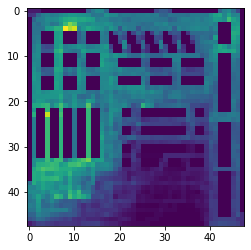

In [73]:
plt.imshow(price_density_grid)

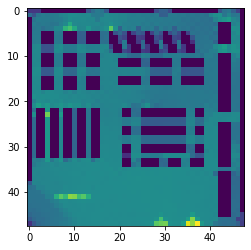

In [74]:
plt.imshow(shopper_density_grid)

### Analysis of Crowd Density

In [75]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", total_loss(shopper_density_grid, price_density_grid))

No of products: 183
Number of products in layout: 0
Total Value 891784.6100000005
Value of Goods bought 891784.6099999878
Total Loss: 890967.0


In [76]:
print("Standard Deviation of Shopper Density:", np.std(shopper_density_grid, axis=(0,1)))
print("Standard Deviation of Price Density:", np.std(price_density_grid, axis=(0,1)))


Standard Deviation of Shopper Density: 2542.6740153744627
Standard Deviation of Price Density: 350.35466883353575


### Debugging Cells